Charging strategy: GENERATION
Strategy status:   ACTIVE

Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 30
Erster Timestamp: 2025-12-01 00:00:00
Letzter Timestamp: 2025-12-07 23:45:00
Simulationshorizont: 7 Tage

📊 Sessions im Simulationshorizont
BEV-Ankünfte mit Ladebedarf: 394
BEV-Fahrzeuge mit Ladezugang: 226
BEV ohne Ladezugang (drive_off): 168
Anzahl der BEV-Fahrzeuge, die nicht ihr Ziel-SoC erreicht haben: 14


,vehicle_name,arrival_time,departure_time,parking_hours,delivered_energy_kwh,remaining_energy_kwh
0,Q4 e-tron,2025-12-02 08:19:19.755997,2025-12-02 08:54:59.351672,0.594332,11.875000,11.566490
1,CLA,2025-12-02 08:14:38.426531,2025-12-02 09:01:05.445569,0.774172,26.125000,11.173375
2,Mokka e,2025-12-04 12:47:44.398481,2025-12-04 13:27:59.706936,0.670919,23.750000,9.133933
3,500e Hatchback,2025-12-03 08:45:49.179643,2025-12-03 09:35:05.206959,0.821119,24.598214,7.772003
4,Macan,2025-12-05 07:28:27.053792,2025-12-05 08:22:06.795759,0.894373,25.729167,6.275327
5,600e,2025-12-03 07:28:52.075449,2025-12-03 08:01:59.447707,0.552048,27.708333,5.427244
6,ID.4 Pro 4Motion,2025-12-06 09:34:02.654255,2025-12-06 10:19:23.304887,0.755736,35.625000,4.859301
7,2 LR DM,2025-12-04 07:13:41.585786,2025-12-04 10:18:40.823510,3.083122,54.873945,4.669153
8,iX xDrive50,2025-12-03 06:58:26.276610,2025-12-03 08:53:59.793393,1.925977,49.649114,3.436789
9,Taycan,2025-12-05 07:58:22.177594,2025-12-05 11:30:36.275138,3.537249,59.296754,3.408903



Kalenderische Tage je Tagtyp:
- working_day: 5 Tage
- saturday: 1 Tage
- sunday_holiday: 1 Tage


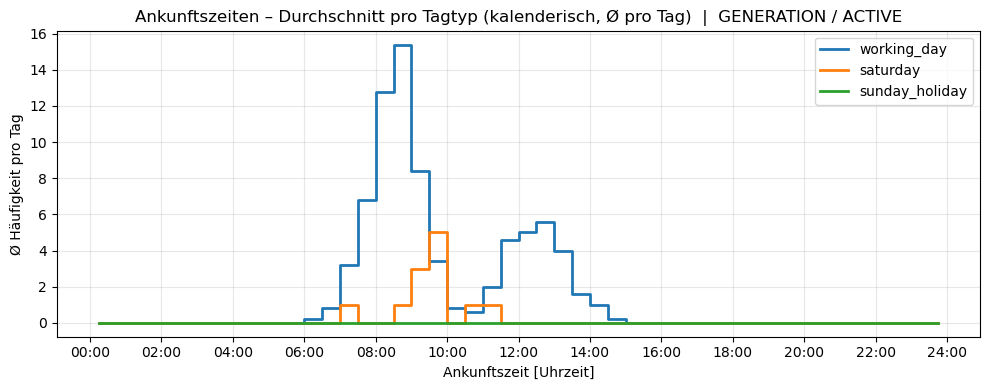

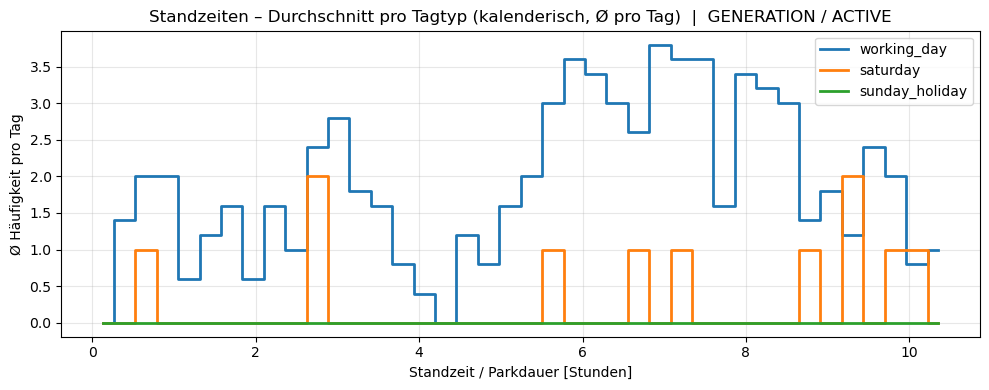

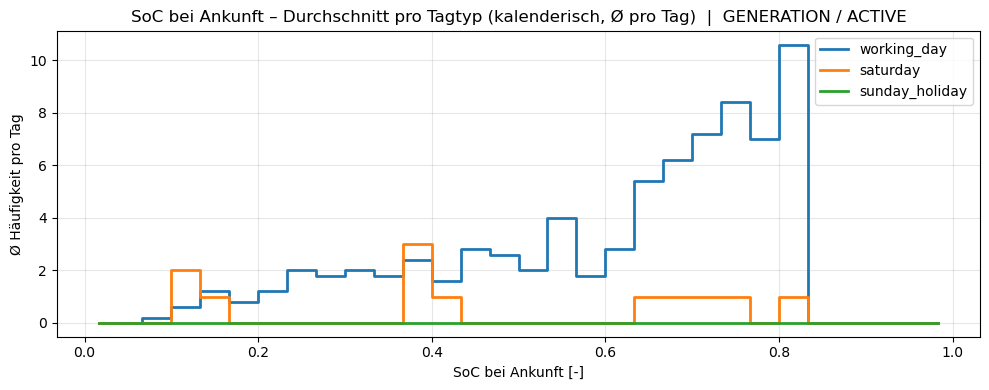

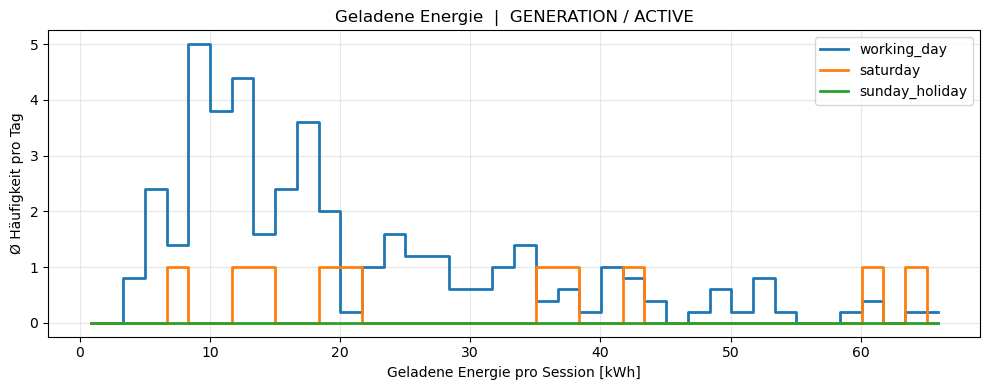

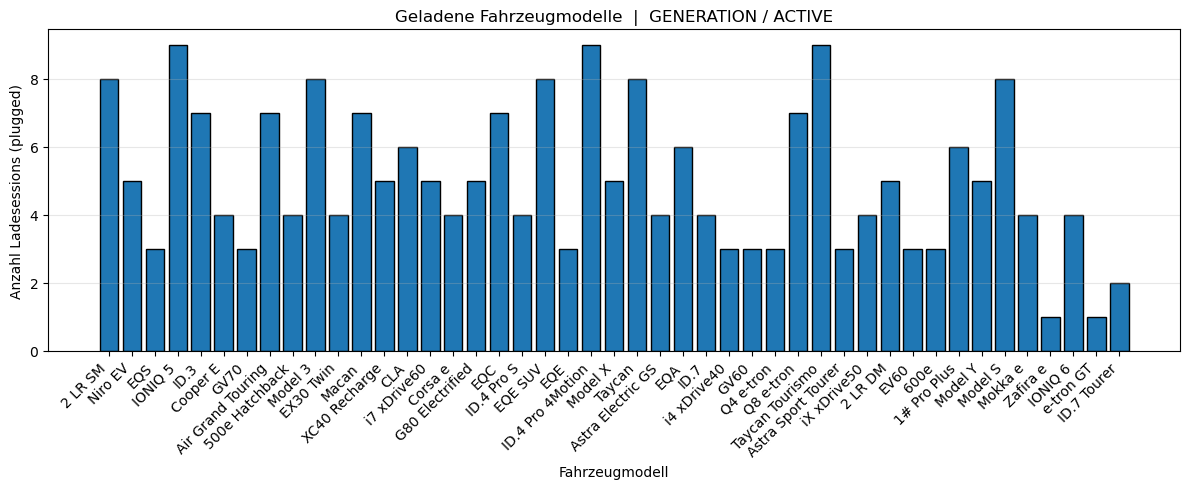

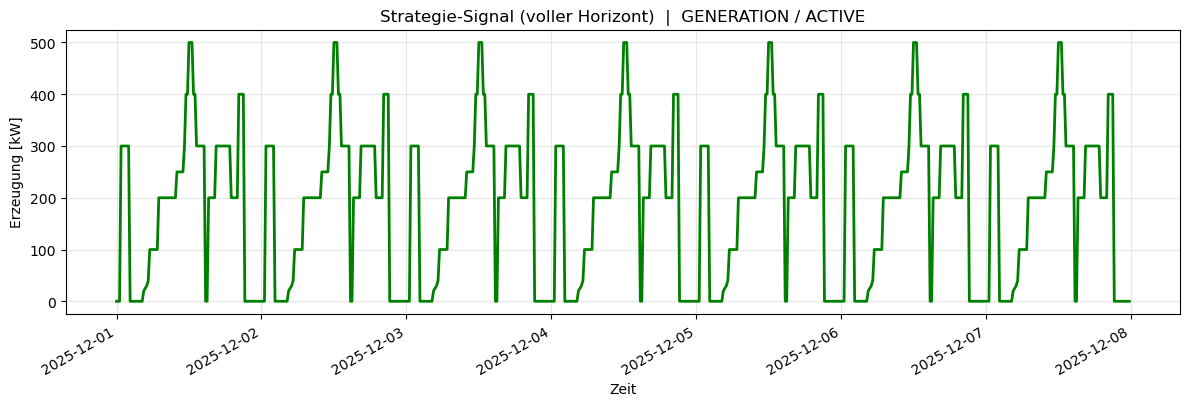

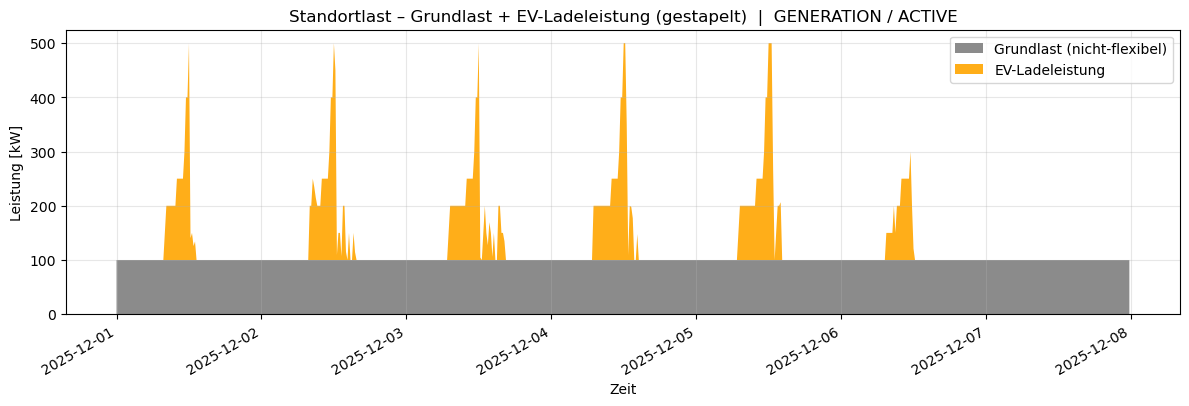

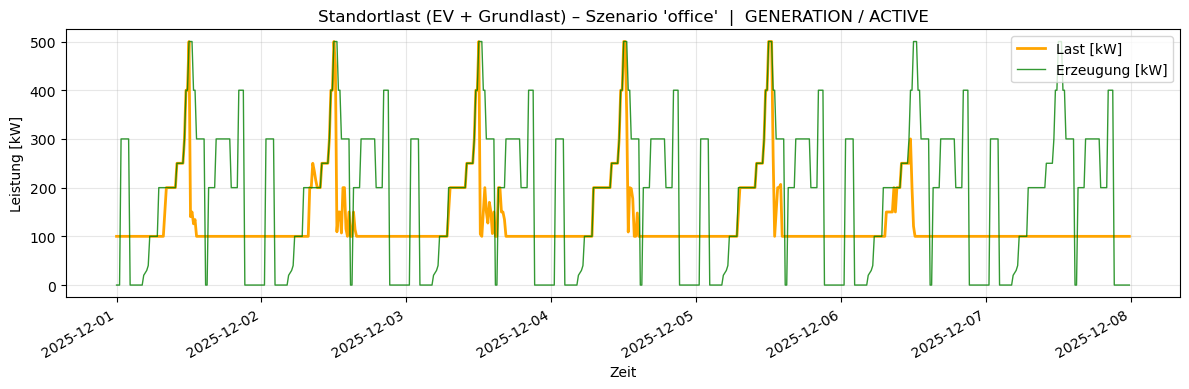

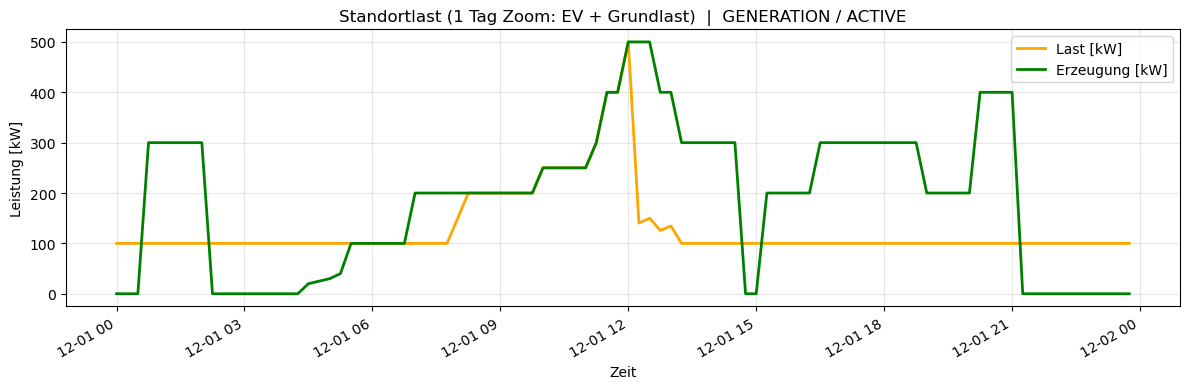


Zeitschritte mit ungenutztem PV-Strom: 51


,ts,pv_surplus_kw,site_power_kw,grid_import_kw,n_rows,pv_unused_kw
70,2025-12-03 12:15:00,400.0,4.532684,0.0,1,395.467316
39,2025-12-02 12:30:00,400.0,9.284399,0.0,2,390.715601
158,2025-12-06 12:00:00,400.0,20.782064,0.0,1,379.217936
17,2025-12-01 12:15:00,400.0,40.401484,0.0,1,359.598516
18,2025-12-01 12:30:00,400.0,50.000000,0.0,1,350.000000
107,2025-12-04 12:45:00,300.0,8.862305,0.0,1,291.137695
19,2025-12-01 12:45:00,300.0,25.742684,0.0,1,274.257316
20,2025-12-01 13:00:00,300.0,34.384771,0.0,1,265.615229
40,2025-12-02 12:45:00,300.0,50.000000,0.0,1,250.000000
41,2025-12-02 13:00:00,300.0,50.000000,0.0,1,250.000000


In [1]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime

warnings.simplefilter("always", UserWarning)
from IPython.display import display, HTML

# =============================================================================
# 0) Plot-Farben (global konsistent)
# =============================================================================
COLOR_GENERATION = "green"    # Erzeugung / PV / Strategy (generation)
COLOR_LOAD = "orange"         # Last / EV / Standortlast
COLOR_BASELOAD = "#7f7f7f"    # Grundlast (neutral grau)


# =============================================================================
# 1) Notebook-UI Helpers (unverändert)
# =============================================================================
def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()

    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}

    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="
        font-size:18px; font-weight:800; color:{color};
        padding:10px 12px; border:2px solid {color};
        border-radius:12px; display:flex; align-items:center;
        gap:10px; width:fit-content; margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);
    ">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# 2) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    build_base_load_series,
    summarize_sessions,
    get_daytype_calendar,
    group_sessions_by_day,
    build_pv_unused_table,
)

# build_strategy_signal_series ist optional (kann in älteren Versionen fehlen)
try:
    from model.simulation import build_strategy_signal_series  # optional
except Exception:
    build_strategy_signal_series = None


# =============================================================================
# 3) Szenario laden und Simulation durchführen
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"
scenario = load_scenario(scenario_path)

try:
    (
        timestamps,
        load_kw,
        sessions,
        charging_counts,
        holiday_dates,
        charging_strategy,
        strategy_status,
        debug_rows,
    ) = simulate_load_profile(scenario, record_debug=True)
except ValueError as e:
    print("\n❌ Simulation abgebrochen:\n")
    print(str(e))
    raise

show_strategy_status_html(charging_strategy, strategy_status)
print(f"Charging strategy: {charging_strategy.upper()}")
print(f"Strategy status:   {strategy_status}")


# =============================================================================
# 4) Strategie-Signalreihe (optional)
# =============================================================================
strategy_series = None
strategy_ylabel = None

if (
    build_strategy_signal_series is not None
    and charging_strategy.lower() in ("market", "generation")
):
    strategy_series, strategy_ylabel = build_strategy_signal_series(
        scenario=scenario,
        timestamps=timestamps,
        charging_strategy=charging_strategy,
        normalize_to_internal=True,  # market -> €/kWh, generation -> kW
        strategy_resolution_min=15,
    )


# =============================================================================
# 5) Kurze Simulation-Infos + KPIs
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")

summary = summarize_sessions(sessions)
print("\n📊 Sessions im Simulationshorizont")
print("BEV-Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("BEV-Fahrzeuge mit Ladezugang:", summary["num_sessions_plugged"])
print("BEV ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

df_not_reached = pd.DataFrame(summary["not_reached_rows"])
if len(df_not_reached) == 0:
    print("Alle BEV-Fahrzeuge haben ihr Ziel-SoC erreicht.")
else:
    df_not_reached = df_not_reached.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print(f"Anzahl der BEV-Fahrzeuge, die nicht ihr Ziel-SoC erreicht haben: {len(df_not_reached)}")
    display(df_not_reached)


# =============================================================================
# 6) Histogramm-Helper (bleibt im Notebook, weil Plotting)
# =============================================================================
def minutes_since_midnight(dt: datetime) -> float:
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s) -> float:
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s) -> float:
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s) -> float:
    return float(s["soc_arrival"])

def feat_delivered_kwh(s) -> float:
    return float(s.get("delivered_energy_kwh", 0.0))

def average_hist_per_daytype_calendar(
    daytype_to_days: dict,
    sessions_by_day: dict,
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type

def plot_avg_hist_overlay(
    avg_counts_by_type,
    bin_edges,
    xlabel,
    base_title,
    charging_strategy,
    strategy_status,
    xticks=None,
    xtick_labels=None,
):
    plt.figure(figsize=(10, 4))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()


# =============================================================================
# 7) Daytype + Gruppierungen (aus simulation.py)
# =============================================================================
start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])

days_by_type_calendar = get_daytype_calendar(
    start_datetime=start_dt,
    horizon_days=horizon_days,
    holiday_dates=holiday_dates,
)

sessions_by_day = group_sessions_by_day(sessions, only_plugged=False)
sessions_by_day_plugged = group_sessions_by_day(sessions, only_plugged=True)

print("\nKalenderische Tage je Tagtyp:")
for k in ["working_day", "saturday", "sunday_holiday"]:
    print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")


# =============================================================================
# 8) Histogramme
# =============================================================================
if timestamps is not None and sessions is not None and days_by_type_calendar:
    # Ankunftszeiten
    arrival_bin_edges = np.linspace(0, 24, 49)
    avg_arrival = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_arrival_hours, arrival_bin_edges)
    plot_avg_hist_overlay(
        avg_arrival, arrival_bin_edges,
        xlabel="Ankunftszeit [Uhrzeit]",
        base_title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        xticks=list(range(0, 25, 2)),
        xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
    )

    # Standzeiten
    all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
    max_p = max(np.percentile(all_parking, 99) if len(all_parking) else 1.0, 0.5)
    parking_bin_edges = np.linspace(0, max_p, 41)
    avg_parking = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_parking_hours, parking_bin_edges)
    plot_avg_hist_overlay(
        avg_parking, parking_bin_edges,
        xlabel="Standzeit / Parkdauer [Stunden]",
        base_title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )

    # SoC bei Ankunft
    soc_bin_edges = np.linspace(0, 1, 31)
    avg_soc = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_soc_arrival, soc_bin_edges)
    plot_avg_hist_overlay(
        avg_soc, soc_bin_edges,
        xlabel="SoC bei Ankunft [-]",
        base_title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )

    # Geladene Energie (plugged-only)
    plugged_list = [s for s in sessions if s.get("_plug_in_time") is not None]
    all_energy = np.array([feat_delivered_kwh(s) for s in plugged_list], dtype=float)
    max_e = max(np.percentile(all_energy, 99) if len(all_energy) else 1.0, 1.0)
    energy_bin_edges = np.linspace(0, max_e, 41)
    avg_energy = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day_plugged, feat_delivered_kwh, energy_bin_edges)
    plot_avg_hist_overlay(
        avg_energy, energy_bin_edges,
        xlabel="Geladene Energie pro Session [kWh]",
        base_title="Geladene Energie",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 9) Fahrzeugzählung (plugged)
# =============================================================================
sessions_plugged = [s for s in sessions if s.get("_plug_in_time") is not None]
counts = Counter([s.get("vehicle_name", "") for s in sessions_plugged])

plt.figure(figsize=(12, 5))
plt.bar(list(counts.keys()), list(counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# 10) Strategy-Only Plot (optional)
# =============================================================================
if strategy_series is not None and strategy_ylabel is not None:
    plt.figure(figsize=(12, 4))
    sig_color = COLOR_GENERATION if charging_strategy.lower() == "generation" else None
    plt.plot(timestamps, strategy_series, linewidth=2, color=sig_color)
    plt.xlabel("Zeit")
    plt.ylabel(strategy_ylabel)
    plt.title(decorate_title_with_status("Strategie-Signal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 11) Standortlast + Strategie (optional) + Grundlast (gestapelt)
# =============================================================================
def plot_load_with_strategy(
    timestamps,
    load_kw: np.ndarray,
    strategy_series: np.ndarray | None,
    strategy_ylabel: str | None,
    base_title: str,
    charging_strategy: str,
    strategy_status: str,
    start_idx: int | None = None,
    end_idx: int | None = None,
    strategy_linewidth: float = 2.0,
    strategy_alpha: float = 1.0,
):
    if start_idx is None:
        start_idx = 0
    if end_idx is None:
        end_idx = len(timestamps)

    x = timestamps[start_idx:end_idx]
    y_load = load_kw[start_idx:end_idx]
    strat = (charging_strategy or "immediate").lower()

    fig, ax1 = plt.subplots(figsize=(12, 4))
    l1 = ax1.plot(x, y_load, label="Last [kW]", color=COLOR_LOAD, linewidth=2)
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    handles = []
    labels = []
    handles += l1
    labels += ["Last [kW]"]

    if strategy_series is not None and strategy_ylabel is not None:
        y_sig = strategy_series[start_idx:end_idx]

        if strat == "market":
            ax2 = ax1.twinx()
            l2 = ax2.plot(x, y_sig, linewidth=strategy_linewidth, alpha=strategy_alpha, label=strategy_ylabel)
            ax2.set_ylabel(strategy_ylabel)
            handles += l2
            labels += [strategy_ylabel]
        elif strat == "generation":
            l2 = ax1.plot(
                x, y_sig,
                linewidth=strategy_linewidth,
                alpha=strategy_alpha,
                label=strategy_ylabel,
                color=COLOR_GENERATION,
            )
            handles += l2
            labels += [strategy_ylabel]

    ax1.set_title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    ax1.legend(handles, labels, loc="upper right")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

base_load_kw_series = build_base_load_series(scenario=scenario, timestamps=timestamps, base_load_resolution_min=15)
if base_load_kw_series is None:
    base_load_kw_series = np.zeros_like(load_kw)

site_load_kw = load_kw + base_load_kw_series

# gestapelt: Grundlast + EV
plt.figure(figsize=(12, 4))
plt.stackplot(
    timestamps,
    base_load_kw_series,
    load_kw,
    labels=["Grundlast (nicht-flexibel)", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Standortlast – Grundlast + EV-Ladeleistung (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# voller Horizont
plot_load_with_strategy(
    timestamps=timestamps,
    load_kw=site_load_kw,
    strategy_series=strategy_series,
    strategy_ylabel=strategy_ylabel,
    base_title=f"Standortlast (EV + Grundlast) – Szenario '{scenario_name}'",
    charging_strategy=charging_strategy,
    strategy_status=strategy_status,
    strategy_linewidth=1.0,
    strategy_alpha=0.8,
)

# 1 Tag Zoom
steps_per_day = int(24 * 60 / scenario["time_resolution_min"])
plot_load_with_strategy(
    timestamps=timestamps,
    load_kw=site_load_kw,
    strategy_series=strategy_series,
    strategy_ylabel=strategy_ylabel,
    base_title="Standortlast (1 Tag Zoom: EV + Grundlast)",
    charging_strategy=charging_strategy,
    strategy_status=strategy_status,
    start_idx=0,
    end_idx=min(steps_per_day, len(timestamps)),
)


# =============================================================================
# 12) PV: Zeitschritte mit ungenutztem PV-Strom (aus simulation.py)
# =============================================================================
df_pv_unused = build_pv_unused_table(debug_rows)
if df_pv_unused is None or len(df_pv_unused) == 0:
    print("\nZeitschritte mit ungenutztem PV-Strom: 0 (oder nicht verfügbar)")
else:
    print(f"\nZeitschritte mit ungenutztem PV-Strom: {len(df_pv_unused)}")
    cols = [c for c in ["ts", "pv_surplus_kw", "site_power_kw", "grid_import_kw", "n_rows", "pv_unused_kw"] if c in df_pv_unused.columns]
    display(df_pv_unused[cols].head(50))
